## 使用MCMC从基于能量的模型（EBM）中采样

### 目标

实现从基于能量的模型（Energy-based Model，EBM）中采样的马尔可夫链蒙特卡罗方法（MCMC）。  
定义一个能量函数 $E(x)$，目标分布为 $p(x) \propto \exp(-E(x))$。通过 MCMC，可以从该分布中采样。

### 背景介绍

- **能量模型（EBM）**：定义了一个能量函数 $E(x)$，目标分布为 $p(x) \propto \exp(-E(x))$。
- **马尔可夫链蒙特卡罗方法（MCMC）**：利用马尔可夫链从复杂的概率分布中采样。核心思想是从一个初始状态  
 $x$ 出发，通过定义的转移概率 $T(x' \mid x)$ 更新状态，最终使得状态 $x$ 的分布接近目标分布 $p(x)$。


### 实现步骤

#### 1. 定义能量函数 $E(x)$

选择一个二维的能量函数，使得目标分布具有多个模式（峰值），以便观察 MCMC 采样的效果。

#### 能量函数示例

考虑以下能量函数：

$$
E(x) = - \log \left( \exp \left( -\frac{(x_1 - 2)^2 + (x_2 - 2)^2}{2} \right) + \exp \left( -\frac{(x_1 + 2)^2 + (x_2 + 2)^2}{2} \right) \right)
$$

该能量函数对应于两个高斯分布的混合，中心分别位于 $(2,2)$ 和 $(-2,-2)$，具有相同的方差。


#### 2. 实现MCMC采样

将使用 Metropolis-Hastings 算法进行采样。

#### Metropolis-Hastings 算法步骤

- **初始状态**：选择一个初始状态 $x^{(0)}$。
- **迭代更新**：
  1. **提议状态**：从提议分布 $q(x' \mid x^{(t)})$ 中采样一个候选状态 $x'$。
  2. **计算接受概率**：

     $$
     \alpha = \min \left( 1, \frac{p(x')}{p(x^{(t)})} \right)
     $$

     对于对称的提议分布（如正态分布），接受概率简化为：

     $$
     \alpha = \min \left( 1, \frac{p(x')}{p(x^{(t)})} \right)
     $$

  3. **接受或拒绝**：以概率 $\alpha$ 接受 $x'$ 作为下一个状态，否则保留当前状态。


### 3. 代码实现

以下将利用PyTorch的自动微分和张量运算能力，进行能量函数计算和 Metropolis-Hastings 采样。


In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 定义能量函数 E(x)
def energy(x):
    # x: Tensor of shape (batch_size, 2)
    x1 = x[:, 0]
    x2 = x[:, 1]
    term1 = torch.exp(-0.5 * ((x1 - 2)**2 + (x2 - 2)**2))
    term2 = torch.exp(-0.5 * ((x1 + 2)**2 + (x2 + 2)**2))
    E = -torch.log(term1 + term2 + 1e-10)  # 加上1e-10防止取log(0)
    return E

# 目标分布 p(x) ∝ exp(-E(x))
def target_distribution(x):
    return torch.exp(-energy(x))


### 实现Metropolis-Hastings采样

In [3]:
def metropolis_hastings(E, initial_state, num_samples, proposal_std):
    samples = []
    x = initial_state
    E_current = E(x)

    for i in range(num_samples):
        # 从提议分布中采样候选状态（二维正态分布）
        x_proposed = x + torch.randn_like(x) * proposal_std
        E_proposed = E(x_proposed)

        # 计算接受概率
        acceptance_prob = torch.exp(E_current - E_proposed).clamp(max=1.0)

        # 采样一个均匀随机数
        u = torch.rand(1)

        # 决定是否接受候选状态
        if u < acceptance_prob:
            x = x_proposed
            E_current = E_proposed

        samples.append(x.detach().numpy())

    return np.array(samples)


### 参数设置和采样

In [4]:
# 参数设置
num_samples = 5000
proposal_std = 1.0
initial_state = torch.tensor([[0.0, 0.0]], requires_grad=False)  # 初始状态

# 运行Metropolis-Hastings算法
samples = metropolis_hastings(energy, initial_state, num_samples, proposal_std)


### 4. 结果可视化

展示通过 MCMC 采样得到的结果。

- **采样轨迹图**：展示采样点在二维空间的轨迹。
- **样本分布图**：绘制采样后的二维分布，应该接近目标分布。

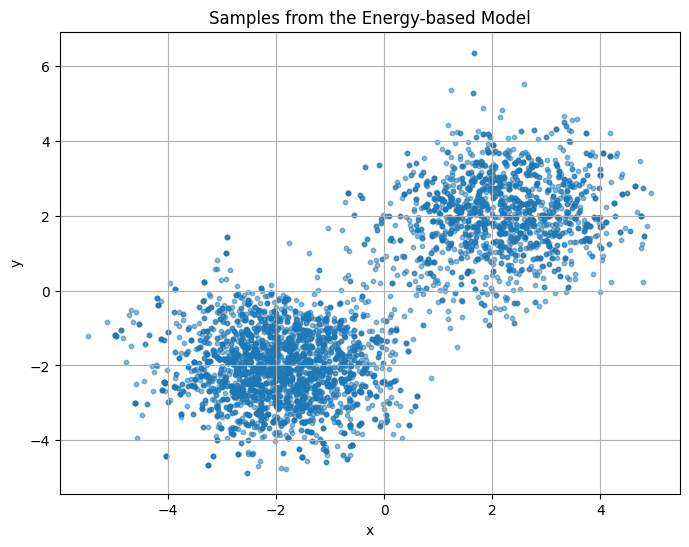

In [5]:
# 提取采样结果
x_samples = samples[:, 0, 0]
y_samples = samples[:, 0, 1]

# 绘制采样结果的散点图
plt.figure(figsize=(8, 6))
plt.scatter(x_samples, y_samples, alpha=0.5, s=10)
plt.title('Samples from the Energy-based Model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


### 绘制能量函数的等高线图

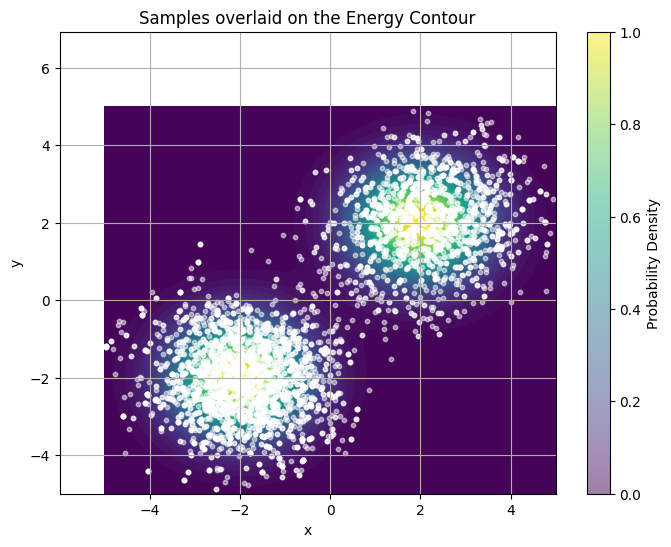

In [6]:
# 创建网格用于绘制等高线
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
XY = np.stack([X.ravel(), Y.ravel()], axis=1)
XY_torch = torch.tensor(XY, dtype=torch.float32)

# 计算能量值
with torch.no_grad():
    E_values = energy(XY_torch).numpy()

E_values = E_values.reshape(X.shape)

# 绘制等高线图和采样点
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, np.exp(-E_values), levels=50, cmap='viridis')
plt.scatter(x_samples, y_samples, alpha=0.5, s=10, color='white')
plt.title('Samples overlaid on the Energy Contour')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Probability Density')
plt.grid(True)
plt.show()


## 结果分析

- **采样结果**：  
  从图中可以看到，采样点集中在能量函数的两个模式附近，说明 MCMC 采样成功地从目标分布中抽取了样本。

- **混合效果**：  
  由于能量函数具有多个模式，MCMC 采样可能在模式之间转换较慢。如果增加采样步数，或调整提议分布的  
  标准差，可以改善混合效果。

## 注意事项

- **初始状态的选择**：  
  为了更好地覆盖目标分布的空间，可以尝试从不同的初始状态开始采样，或者使用多个马尔可夫链。

- **提议分布的标准差**：  
  提议分布的标准差对于采样效率有重要影响。标准差过小，采样会在局部区域徘徊；标准差过大，接受率  
  会降低。需要根据具体情况进行调整。

- **Burn-in 期**：  
  通常在采样开始的阶段，样本可能还未达到平稳分布，可以丢弃一定数量的初始样本作为磨合期。
